## **MANSI KAKKAR (EE21S063)**

# **PROGRAMMING ASSIGNMENT 3 OF DEEP LEARNING FOR IMAGING (EE5179)**

___
___

# **MNIST Digit Classification using RNNs**



*While running the code for final time couldnt run it in GPU on Colab, So ran all the codes on CPU, Kindly uncomment where #cuda is written, then it the code will run for the required results*

# Part - 1

## Libraries

In [1]:
import sys
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split

torch.manual_seed(2111)

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots

In [3]:
#Setting the device to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### Intialisation

In [4]:
batch_size = 500
input_size = 28
learning_rate = 1e-2
epochs = 5



In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)),])
dataset = datasets.MNIST(root = "data/", train = True, transform = transform, download = True)
test_dataset = datasets.MNIST(root = "data/", train = False, transform = transform, download = True)

#Splitting the Training dataset
train_dataset, validation_dataset = train_test_split(dataset, test_size=10000, train_size = 50000, random_state = None, shuffle = True)

print(f"number of train samples: {len(train_dataset)}")
print(f"number of validation samples: {len(validation_dataset)}")
print(f"number of test samples: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
validation_loader = DataLoader(validation_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

number of train samples: 50000
number of validation samples: 10000
number of test samples: 10000


## Data Loading

In [6]:
print(f"size of train dataloader is :{len(train_loader)}")
print(f"size of validation dataloader is :{len(validation_loader)}")
print(f"size of test dataloader is :{len(test_loader)}")
data = next(iter(train_loader))
img, target = data
target
print(f"Train image shape:{img.shape}")
print(f"Train Targets shape:{target.shape}")

data = next(iter(validation_loader))
img, target = data
target
print(f"Validation image shape:{img.shape}")
print(f"Validation Targets shape:{target.shape}")

data = next(iter(test_loader))
img, target = data
target
print(f"Test image shape:{img.shape}")
print(f"Test Targets shape:{target.shape}")

size of train dataloader is :100
size of validation dataloader is :20
size of test dataloader is :20
Train image shape:torch.Size([500, 1, 28, 28])
Train Targets shape:torch.Size([500])
Validation image shape:torch.Size([500, 1, 28, 28])
Validation Targets shape:torch.Size([500])
Test image shape:torch.Size([500, 1, 28, 28])
Test Targets shape:torch.Size([500])


# RNN Classification

---

**Comprising of:**

## - Vanilla RNN
## - LSTM
## - GRU

*With Bi DIrectional portion in the classes as well*

In [7]:
class vanilla_rnn(nn.Module):
  def __init__(self, input_size = 28, hidden_dim = 128, bi_directional = False):
    super(vanilla_rnn, self).__init__()

    self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_dim, num_layers = 1, bidirectional = bi_directional, batch_first = True)
    self.hidden_layer = nn.Linear(hidden_dim + hidden_dim*bi_directional, 10)
    self.logsoftmax = nn.LogSoftmax(dim = 1)
    
  def forward(self, x):
    # x = x.permute(1, 0, 2)
    out, hidden = self.rnn(x)
    out = self.hidden_layer(out[:, -1, :])
    pred = self.logsoftmax(out)
    return pred





In [8]:
class LSTM(nn.Module):
  
  def __init__(self, input_size = 28, hidden_dim = 100, bi_directional = False):
    super(LSTM, self).__init__()
    self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_dim, bidirectional = bi_directional)
    self.layer2 = nn.Linear(hidden_dim + hidden_dim*bi_directional, 10)
    self.bd = bi_directional
    self.hidden = hidden_dim
  
  def forward(self, X):
    h0 = torch.zeros(1 + 1*self.bd, X.size(0), self.hidden)#.cuda()
    c0 = torch.zeros(1 + 1*self.bd, X.size(0), self.hidden)#.cuda()
    X = X.permute(1,0,2)
    out,(hs,cs) = self.lstm(X,(h0,c0)) 
    out = self.layer2(out[27])
    # pred = self.logsoftmax(out)
    return out.reshape(500,10)

In [9]:
class gru(nn.Module):
  def __init__(self, input_size = input_size, hidden_dim = 128, bi_directional = False):
    super(gru, self).__init__()
    self.gru = nn.GRU(input_size = input_size, hidden_size = hidden_dim, num_layers = 1, bidirectional = bi_directional, batch_first = True)
    self.hidden_layer = nn.Linear(hidden_dim + hidden_dim*bi_directional, 10)
    self.logsoftmax = nn.LogSoftmax(dim = 1)
    self.bd = bi_directional
    self.hd = hidden_dim

  def forward(self, x):
    h0 = torch.zeros(1 + 1*self.bd, x.size(0), self.hd).requires_grad_()#.cuda()
    out, h = self.gru(x, (h0))
    out = self.hidden_layer(out[:, -1, :])
    pred = self.logsoftmax(out)
    return pred

## Train + Validate Function + Test Function

In [10]:
def train_validate(model, optimizer, criterion, device = 'cuda' if torch.cuda.is_available() else 'cpu', epochs = 7):
  model.train()
  train_loss = []
  train_accuracy = []
  val_loss = []
  val_accuracy = []
  

  for epoch in range(epochs):
    val_correct = 0
    iter = 0
    valloss = 0
    train_correct = 0
    
    print(f'for epoch = {epoch}\n')
    for idx,(data, label) in enumerate(train_loader):
      
      data = data.to(device)
      label = label.to(device)
      data = data.view(-1, 28, 28)
      pred = model(data)
      loss = criterion(pred, label)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      _, predicted = torch.max(pred.data, 1)
      train_correct += (predicted == label).sum().item()
    
    train_loss.append(loss.item())
    train_accuracy.append(train_correct/100)
    
    for idx,(data, label) in enumerate(validation_loader):
      
      data = data.to(device)
      label = label.to(device)
      data = data.view(-1, 28, 28)
      pred = model(data)
      loss = criterion(pred, label)
      valloss+= loss.item()
      _, predicted = torch.max(pred.data, 1)
      val_correct += (predicted == label).sum().item()
      iter+=1
    
    val_loss.append(valloss/iter)
    val_accuracy.append(val_correct/100)
  
  return train_loss, train_accuracy, val_loss, val_accuracy



def test(model, criterion, device = 'cuda' if torch.cuda.is_available() else 'cpu'):
  model.eval()
  test_loss = []
  test_accuracy = []
  test_correct = 0
  with torch.no_grad():
    for idx,(data, label) in enumerate(test_loader):
      data = data.to(device)
      label = label.to(device)
      data = data.view(-1,28,28)
      pred = model(data)
      loss = criterion(pred, label).item()
      _, predicted = torch.max(pred.data, 1)
      test_correct += (predicted == label).sum().item()
      test_loss.append(loss)
    test_accuracy.append(test_correct/100)

  return test_loss, test_accuracy

# Visualisation Function

In [11]:
def visualise_loss(model_type, loss_type, loss_list):
  plt.figure()
  xloss=np.arange(len(loss_list))
  plt.plot(xloss, loss_list, label = model_type)
  plt.grid(b=True, which='major', color='#666666', linestyle='-')
  plt.minorticks_on()
  plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
  plt.legend()
  plt.xlabel('Iterations')
  plt.ylabel(loss_type + ' Loss')
  plt.title(model_type + ' accuracy vs epochs')

def visualise_accuracy(model_type, loss_type, loss_list, accuracy):
  plt.figure()
  xloss=np.arange(len(loss_list))
  plt.plot(xloss, accuracy, label = model_type)
  plt.grid(b=True, which='major', color='#666666', linestyle='-')
  plt.minorticks_on()
  plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
  plt.xlabel('Epochs')
  plt.ylabel(loss_type + 'Accuracy')
  plt.title(model_type + 'accuracy vs epochs')


# Function to call different models

In [18]:
def call_model(model, model_type, epochs):
  optimizer = optim.Adam(model.parameters(), lr = learning_rate)
  criterion = nn.CrossEntropyLoss()
  train_loss, train_acc, val_loss, val_acc = train_validate(model, optimizer, criterion, device, epochs)
  visualise_loss(model_type, 'Training', train_loss)
  visualise_loss(model_type, 'Validation', val_loss)
  visualise_accuracy(model_type, 'Validation', val_loss, val_acc)
  print(f'The Accuracy for Validation set is : {val_acc}%')
  test_loss, test_acc = test(model, criterion, device)
  visualise_loss(model_type, 'Testing', test_loss)
  print(f'the test accuracy for {model_type} is = {test_acc}%')

## **RNN Model**

for epoch = 0

for epoch = 1

for epoch = 2

for epoch = 3

for epoch = 4

The Accuracy for Validation set is : [80.13, 81.76, 89.19, 89.83, 86.46]%
the test accuracy for RNN is = [87.02]%


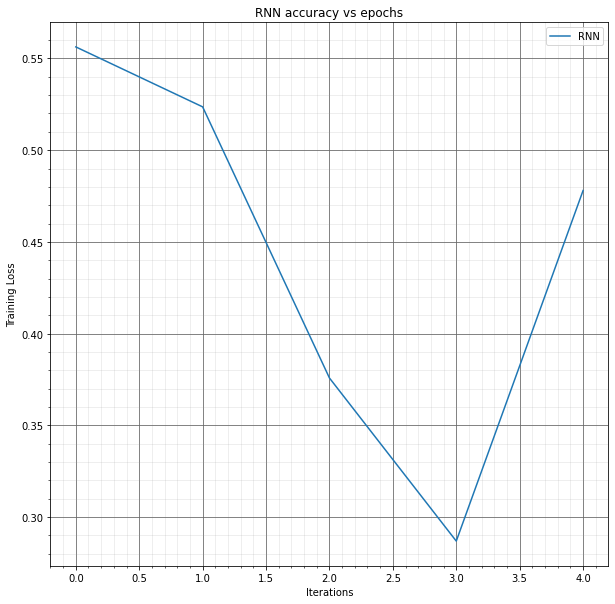

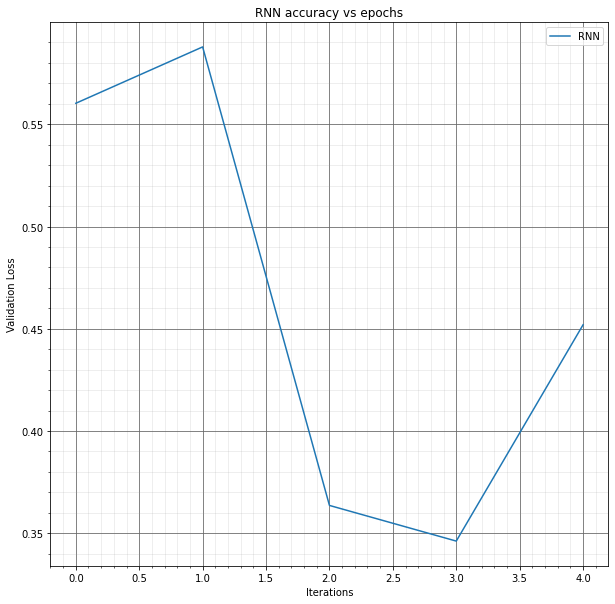

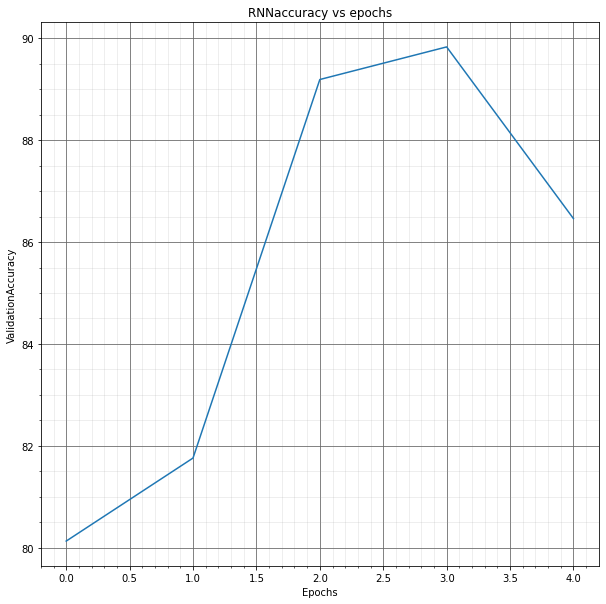

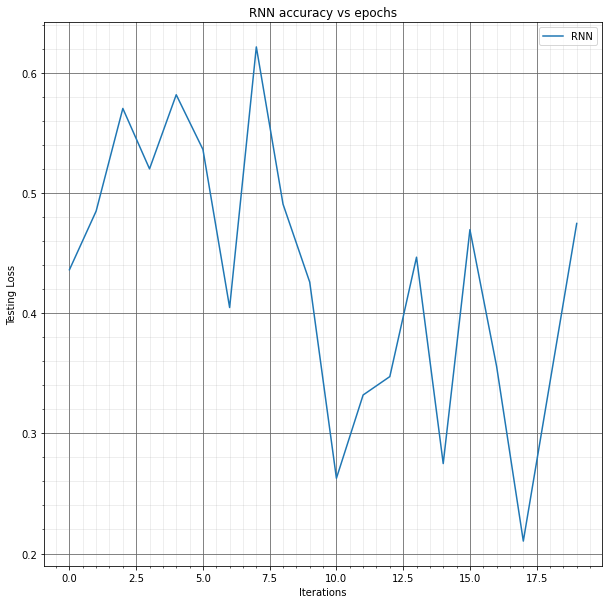

In [19]:
model_rnn = vanilla_rnn().to(device)
call_model(model_rnn, 'RNN', epochs = 5)


## **LSTM Model**

for epoch = 0

for epoch = 1

for epoch = 2

for epoch = 3

for epoch = 4

for epoch = 5

for epoch = 6

The Accuracy for Validation set is : [95.54, 97.14, 97.01, 97.65, 97.61, 98.03, 97.79]%
the test accuracy for LSTM is = [98.11]%


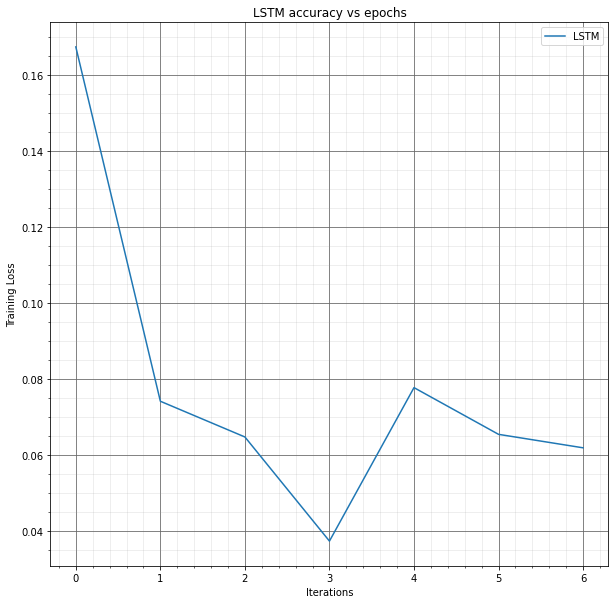

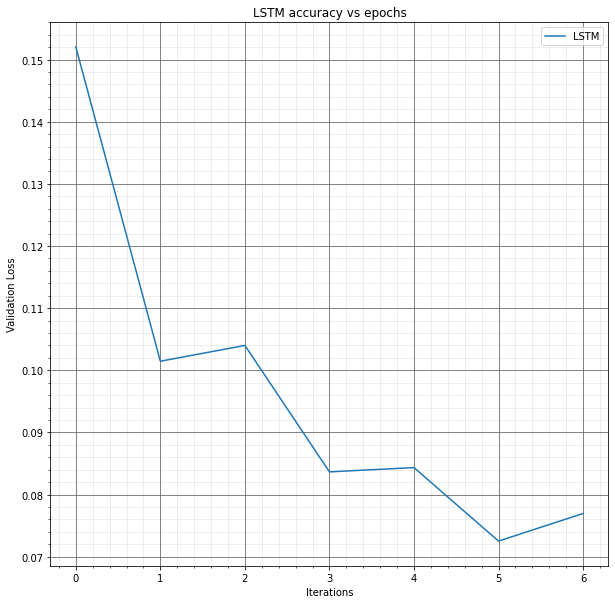

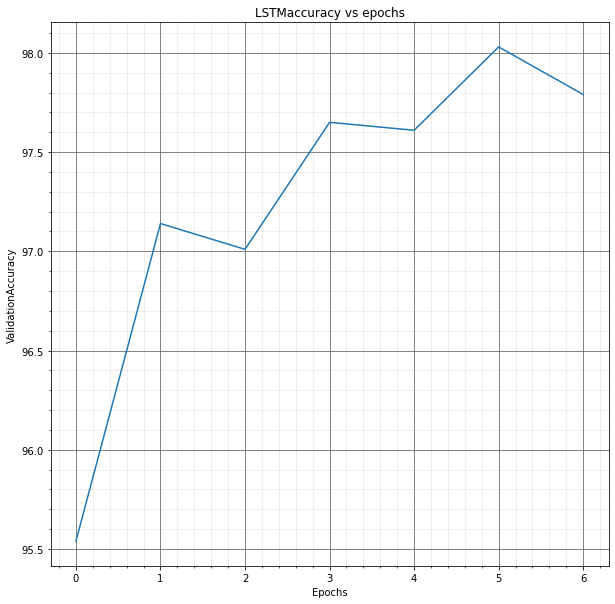

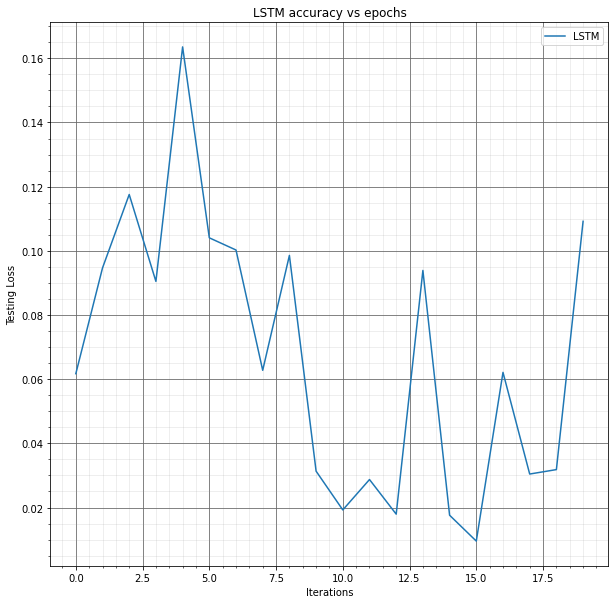

In [20]:
model_lstm = LSTM().to(device)
call_model(model_lstm, 'LSTM', epochs = 7)

## **GRU Model**

for epoch = 0

for epoch = 1

for epoch = 2

for epoch = 3

for epoch = 4

for epoch = 5

for epoch = 6

The Accuracy for Validation set is : [96.8, 97.67, 97.84, 97.76, 98.14, 97.9, 98.22]%
the test accuracy for GRU is = [98.35]%


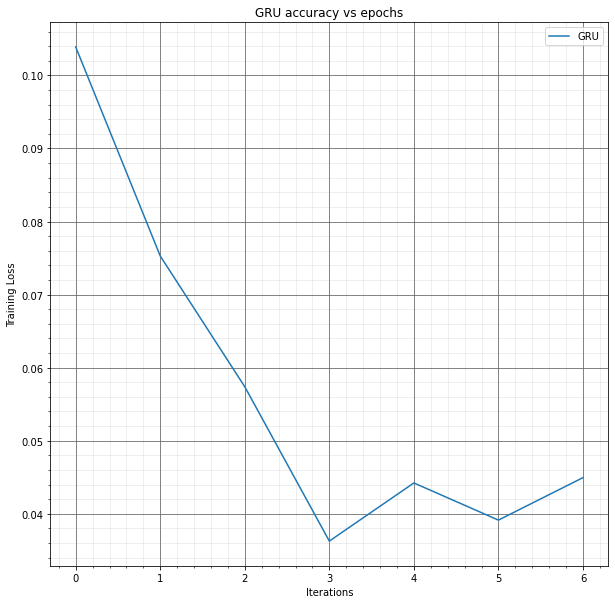

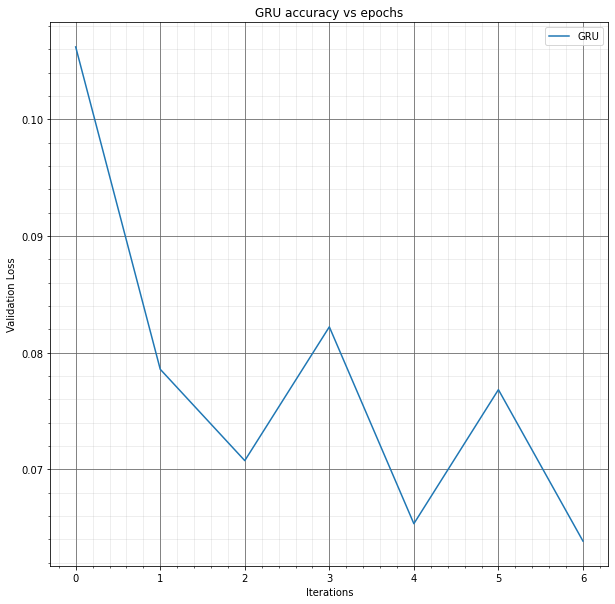

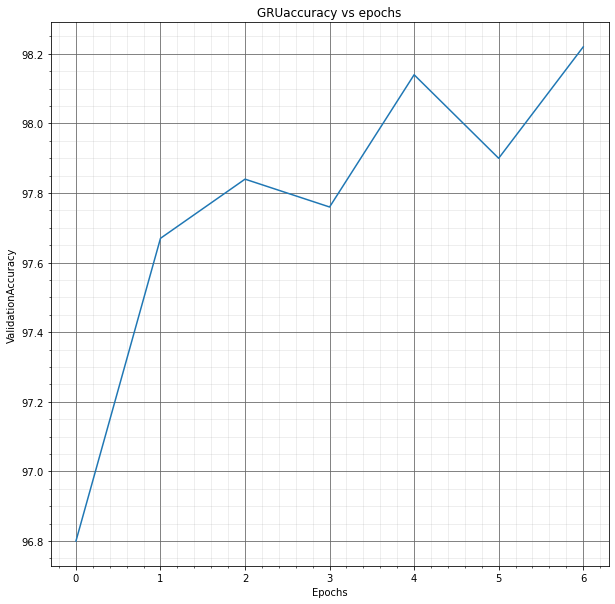

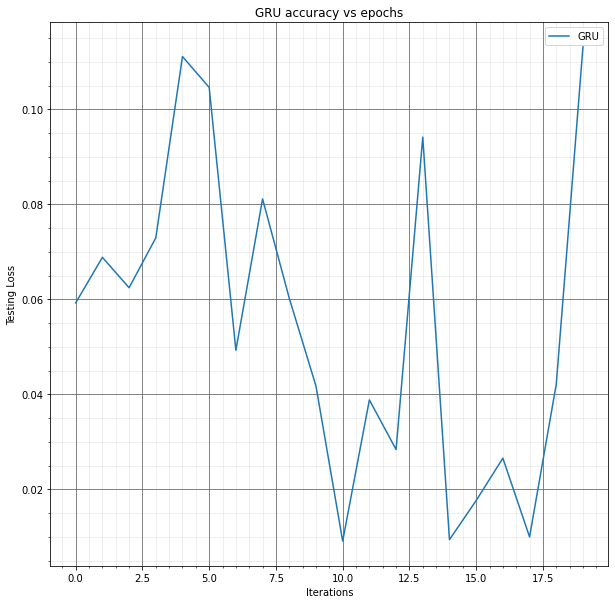

In [21]:
model_gru = gru().to(device)
call_model(model_gru, 'GRU', epochs = 7)


# **For Bi - Directional**

## **Bi - RNN**

for epoch = 0

for epoch = 1

for epoch = 2

for epoch = 3

for epoch = 4

The Accuracy for Validation set is : [81.48, 85.11, 85.17, 88.45, 87.01]%
the test accuracy for RNN is = [88.34]%


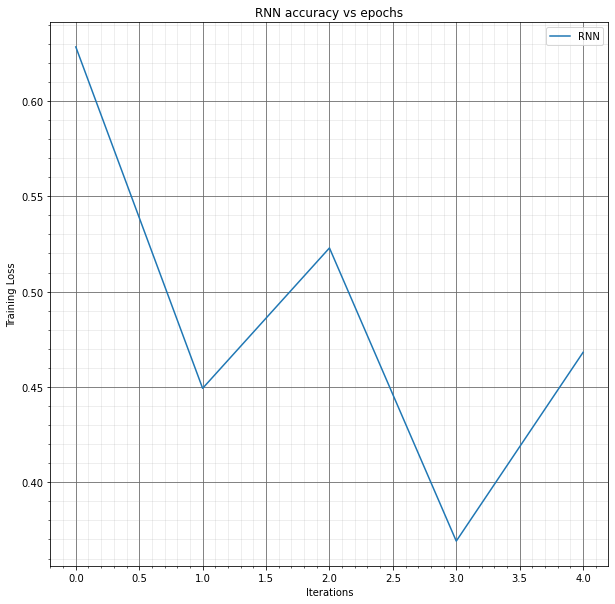

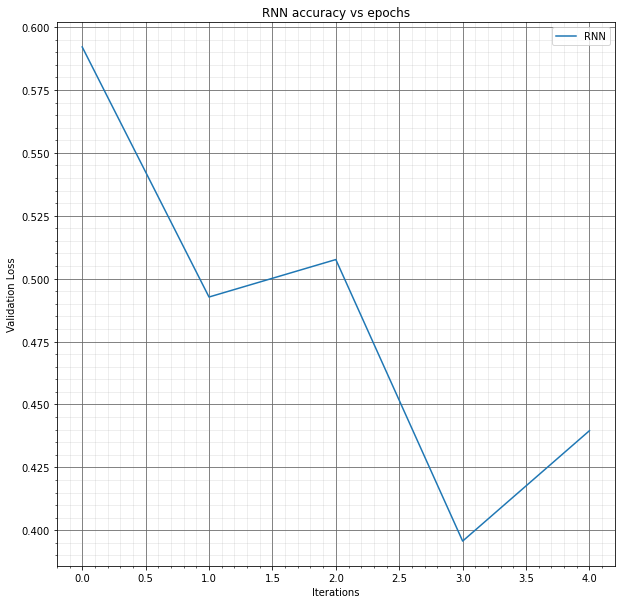

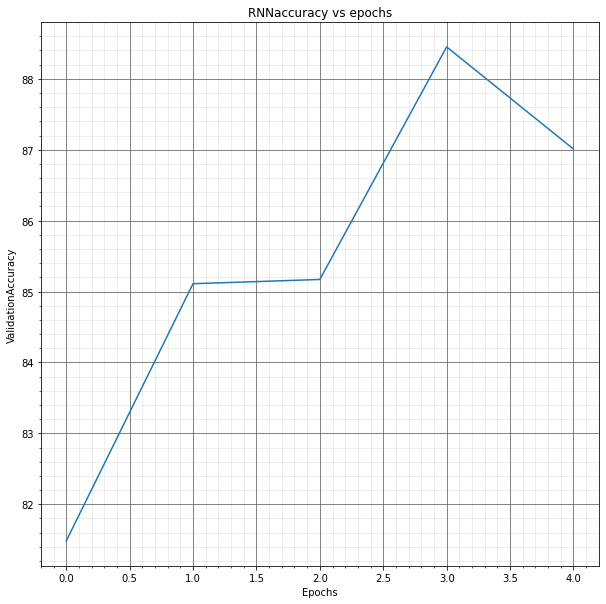

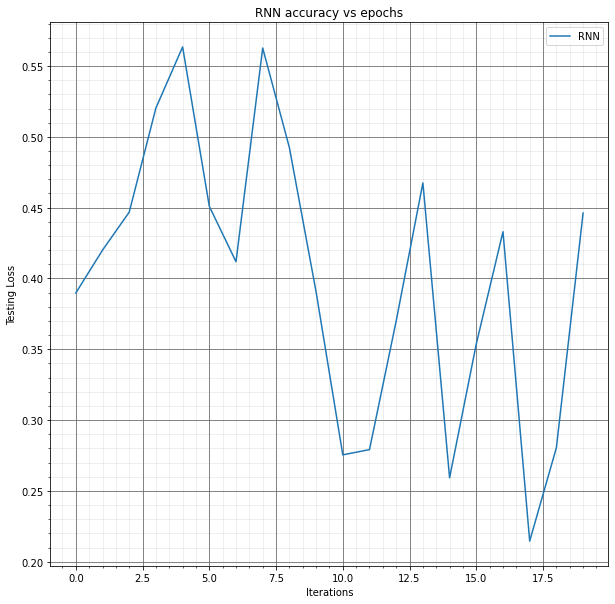

In [22]:
model_rnn = vanilla_rnn(bi_directional = True).to(device)
call_model(model_rnn, 'RNN', epochs = 5)


## **Bi-LSTM**

for epoch = 0

for epoch = 1

for epoch = 2

for epoch = 3

for epoch = 4

for epoch = 5

for epoch = 6

The Accuracy for Validation set is : [94.6, 97.13, 97.7, 97.81, 97.62, 97.94, 98.1]%
the test accuracy for LSTM is = [98.1]%


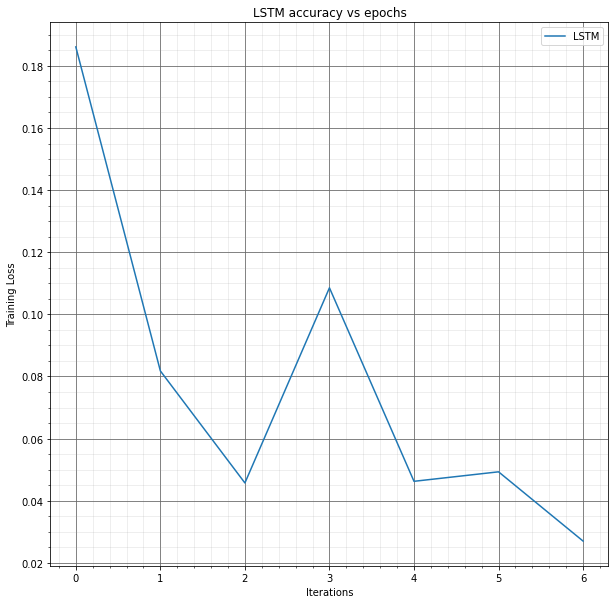

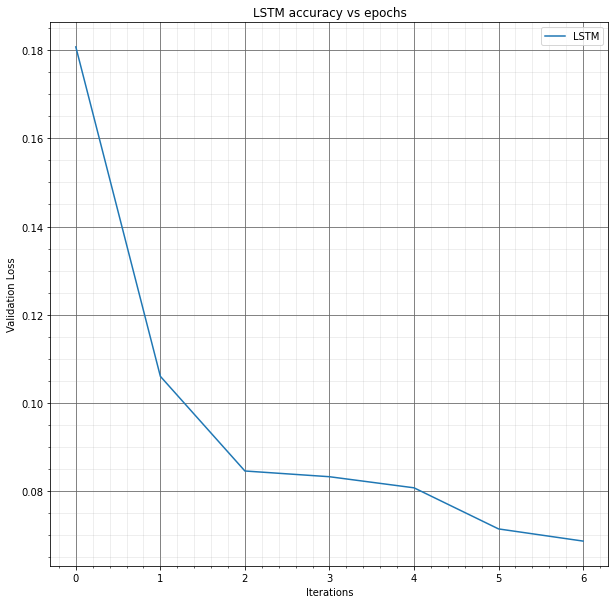

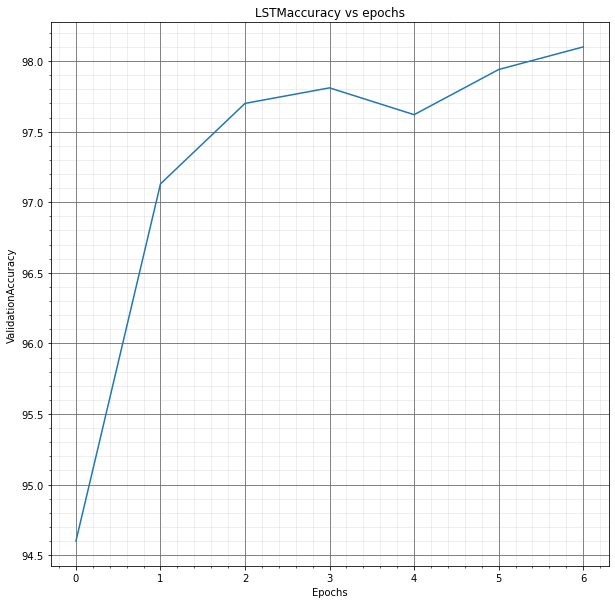

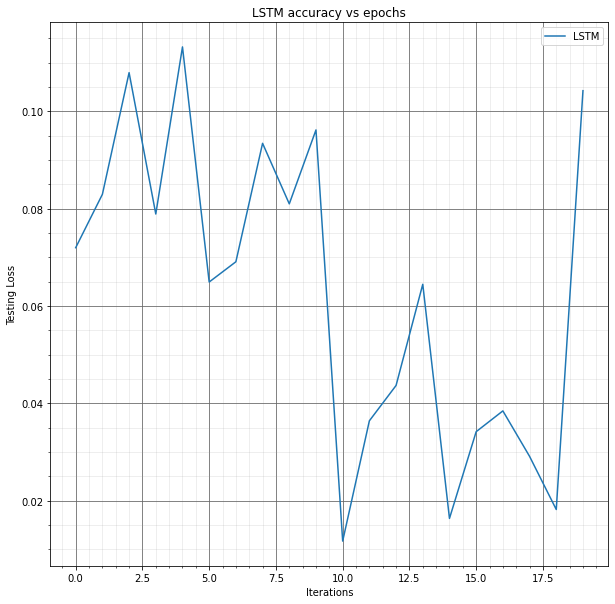

In [23]:
model_lstm = LSTM(bi_directional = True).to(device)
call_model(model_lstm, 'LSTM', epochs = 7)

In [24]:
data = next(iter(train_loader))
img, target = data

# Observations:

* For Vanilla RNN: 
  - Validation Accuracy is: 86%
  - Test Accuracy is: 87%

* For LSTM:
  - Validation Accuracy is: 97.79%
  - Test Accuracy is: 98.11%

* For GRU:
  - Validation Accuracy is: 98.22%
  - Test Accuracy is: 98.35%

* For Bi_Directional RNN:
  - Validation Accuracy is: 87.01%
  - Test Accuracy is: 88.34%

* For Bi_Directional LSTM:
  - Validation Accuracy is: 98.1%
  - Test Accuracy is: 98.1%


Thus, LSTM and GRU Perform almost at par whereas RNN model doesnot perform as good as LSTMs and GRUs. Considering Bi-Directional RNN performs better than Vanilla RNN, Considerable changes are not observed that much in LSTMs and GRUs. The reason for this can be that initially only these model are good and hence considerable changes are not observed when we try to improve their accuracy.



## Visualise the Images and their Predicted and Actual labels

Prediction: [5. 6. 6. 5. 5. 7. 5. 7. 7. 5.]
Real label: [5. 6. 6. 5. 5. 7. 5. 7. 7. 5.]
Images:


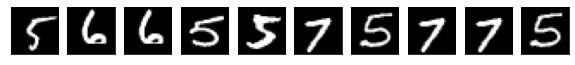

In [34]:
p = 1
a = (10*np.abs(np.random.rand(10))).astype(int)
predict = np.zeros(10)
actual = np.zeros(10)
fig,ax = plt.subplots()
for i in range(10):
  ax = plt.subplot(1,10,p)
  ax.set_xticks([])
  ax.set_yticks([])
  img = img.reshape(-1,28,28)
  im=ax.imshow(img[a[i]],cmap='gray')
  _,predicted=torch.max(model_lstm(img)[a[i]],0)
  predict[i]=predicted.item()
  actual[i]=target[a[i]]
  p+=1
plt.show
print('Prediction:',predict)
print('Real label:',actual)
print('Images:')

# **Part - 2**

## Random Number Generator
## One hot Encoder Function

In [91]:
def random_number(n):
  numlist = np.random.randint(0, 10, n)
  return numlist

def one_hot_encoder(Y):
  output = np.eye(10)[np.array(Y).reshape(-1)]
  return output.reshape(list(np.shape(Y))+[10])


In [92]:
class LSTM_for_Q2(nn.Module):
  def __init__(self,hidden_size):
    super(LSTM_for_Q2, self).__init__()
    self.hidden_size=hidden_size
    self.lstm = nn.LSTM(10,hidden_size)
    self.layer2 = nn.Linear(hidden_size, 10)
    
  def forward(self, X):
    h0 = torch.zeros(1,X.size(0),self.hidden_size)#.cuda()
    c0 = torch.zeros(1,X.size(0),self.hidden_size)#.cuda()
    X=X.permute(1,0,2)
    out,(hs,cs) = self.lstm(X,(h0,c0)) 
    out = self.layer2(out[-1])
    return out.reshape(1,10)

In [93]:
trainranlist=[]
valranlist=[]
testranlist=[]
for i in range(100):
  for j in range(3,11):
    trainranlist.append(random_number(j))
  L=np.random.randint(3,11)
  valranlist.append(random_number(L))
  L=np.random.randint(3,11)
  testranlist.append(random_number(L))  

In [94]:
criterion = nn.CrossEntropyLoss()
epochs = 10
learning_rate = 0.002

K=1
hidstatesize=[2,5,10]
traininglosslist2=[]
validationaccuracy_list2=[]
traininglosslist5=[]
validationaccuracy_list5=[]
traininglosslist10=[]
validationaccuracy_list10=[]
iteration=0
tempvalloss=0
correctval=0  

model1=LSTM_for_Q2(hidstatesize[0])
optimizer1 = torch.optim.Adam(model1.parameters(), lr=learning_rate)

for epoch in range(epochs):
  for i in range(len(trainranlist)):  
    hotranlist=torch.zeros((1,len(trainranlist[i]),10))
    hotranlist[0]=torch.from_numpy(one_hot_encoder(trainranlist[i]))
    
    output=model1(hotranlist.float())
    _,predicted=torch.max(output.data,1)
    
    label=torch.tensor([trainranlist[i][K]],dtype=torch.long)
    loss = criterion(output, label.long())
    traininglosslist2.append(loss.item())
    
    optimizer1.zero_grad()
    loss.backward()
    optimizer1.step()
  
  iteration=0
  tempvalloss=0
  correctval=0 
    
  for i in range(len(valranlist)):  
    hotranlist=torch.zeros((1,len(valranlist[i]),10))
    hotranlist[0]=torch.from_numpy(one_hot_encoder(valranlist[i]))
    
    output=model1(hotranlist.float())
    _,predicted=torch.max(output.data,1)
    
    label=torch.tensor([valranlist[i][K]],dtype=torch.long)
    _, predicted = torch.max(output.data, 1)
    correctval += (predicted == label).sum().item()
    iteration+=1
  validationaccuracy_list2.append(correctval/len(valranlist)*100)


model2=LSTM_for_Q2(hidstatesize[1])
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate)

for epoch in range(epochs):
  for i in range(len(trainranlist)):  
    hotranlist=torch.zeros((1,len(trainranlist[i]),10))
    hotranlist[0]=torch.from_numpy(one_hot_encoder(trainranlist[i]))
    
    output=model2(hotranlist.float())
    _,predicted=torch.max(output.data,1)
    
    label=torch.tensor([trainranlist[i][K]],dtype=torch.long)
    loss = criterion(output, label.long())
    traininglosslist5.append(loss.item())
    
    optimizer2.zero_grad()
    loss.backward()
    optimizer2.step()
    
  iteration=0
  tempvalloss=0
  correctval=0 
  
  for i in range(len(valranlist)):  
    hotranlist=torch.zeros((1,len(valranlist[i]),10))
    hotranlist[0]=torch.from_numpy(one_hot_encoder(valranlist[i]))
    output=model2(hotranlist.float())
    _,predicted=torch.max(output.data,1)
    
    label=torch.tensor([valranlist[i][K]],dtype=torch.long)
    _, predicted = torch.max(output.data, 1)
    correctval += (predicted == label).sum().item()
    iteration+=1
      
  validationaccuracy_list5.append(correctval/len(valranlist)*100)
  

model3=LSTM_for_Q2(hidstatesize[2])
optimizer3 = torch.optim.Adam(model3.parameters(), lr=learning_rate)

for epoch in range(epochs):
  for i in range(len(trainranlist)):  
    hotranlist=torch.zeros((1,len(trainranlist[i]),10))
    hotranlist[0]=torch.from_numpy(one_hot_encoder(trainranlist[i]))
    
    output=model3(hotranlist.float())
    _,predicted=torch.max(output.data,1)
    
    label=torch.tensor([trainranlist[i][K]],dtype=torch.long)
    loss = criterion(output, label.long())
    traininglosslist10.append(loss.item())
    
    optimizer3.zero_grad()
    loss.backward()
    optimizer3.step()
    
  iteration=0
  tempvalloss=0
  correctval=0 

  for i in range(len(valranlist)):  
    hotranlist=torch.zeros((1,len(valranlist[i]),10))
    hotranlist[0]=torch.from_numpy(one_hot_encoder(valranlist[i]))
    
    output=model3(hotranlist.float())
    _,predicted=torch.max(output.data,1)
    
    label=torch.tensor([valranlist[i][K]],dtype=torch.long)
    _, predicted = torch.max(output.data, 1)
    correctval += (predicted == label).sum().item()
    iteration+=1
      
  validationaccuracy_list10.append(correctval/len(valranlist)*100)

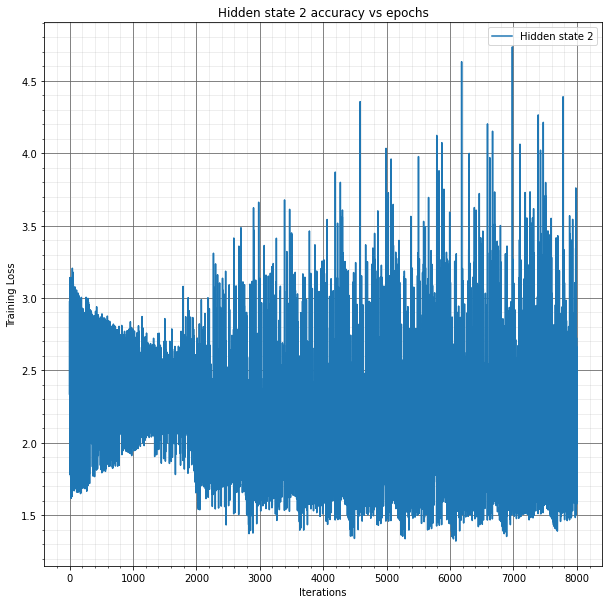

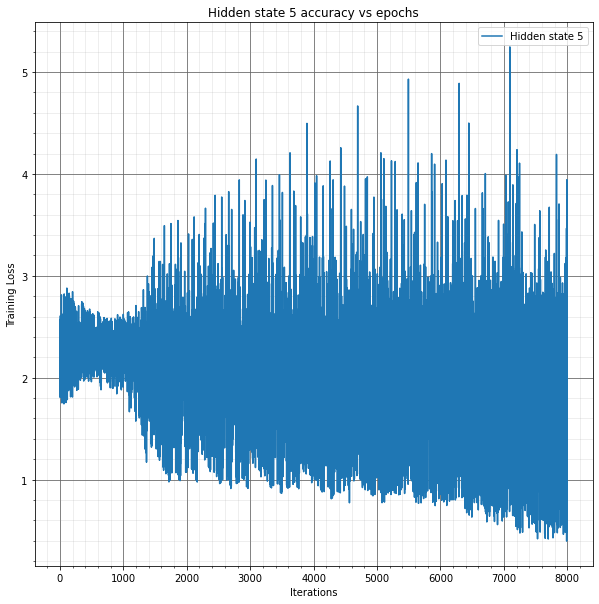

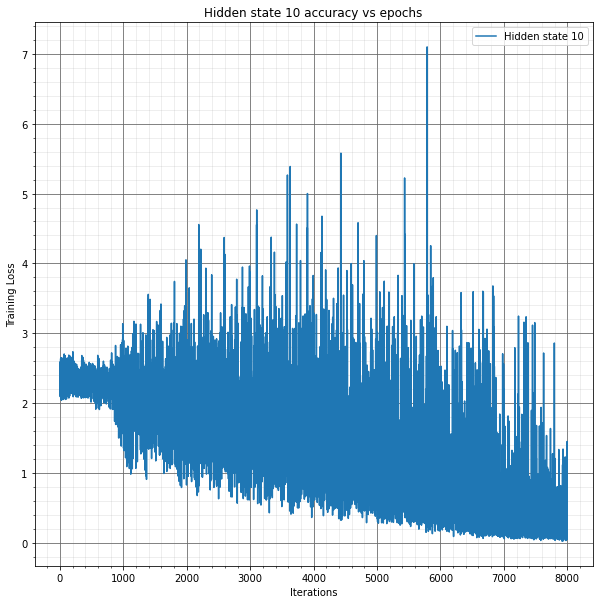

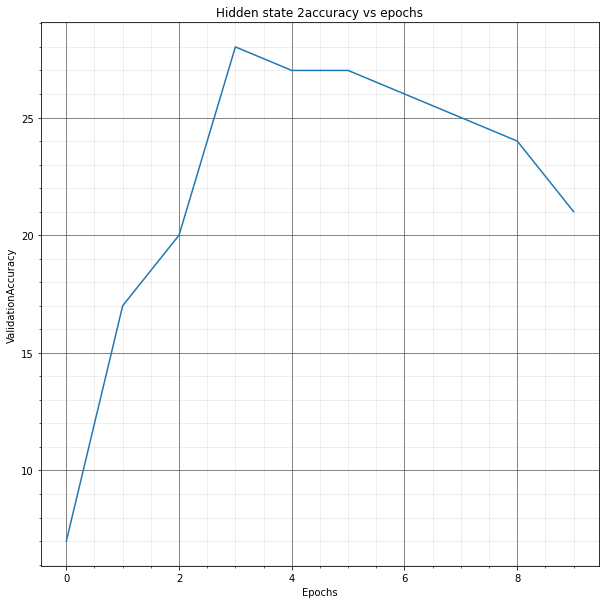

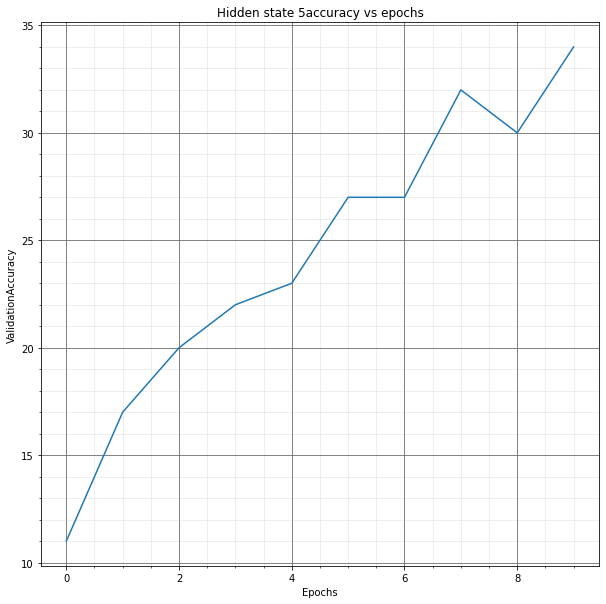

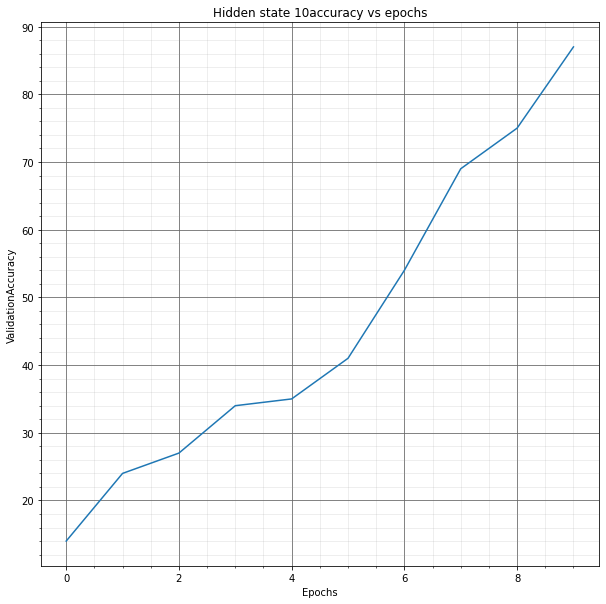

In [95]:
visualise_loss("Hidden state 2","Training", traininglosslist2)
visualise_loss("Hidden state 5","Training", traininglosslist5)
visualise_loss("Hidden state 10","Training", traininglosslist10)
visualise_accuracy("Hidden state 2", "Validation", validationaccuracy_list2, validationaccuracy_list2)
visualise_accuracy("Hidden state 5", "Validation", validationaccuracy_list5, validationaccuracy_list5)
visualise_accuracy("Hidden state 10", "Validation", validationaccuracy_list10, validationaccuracy_list10)


In [96]:
model1.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i in range(len(testranlist)):
      hotranlist=torch.zeros((1,len(testranlist[i]),10))
      hotranlist[0]=torch.from_numpy(one_hot_encoder(testranlist[i]))
      output=model1(hotranlist.float())
      label=torch.tensor([testranlist[i][K]],dtype=torch.long)
      _, predicted = torch.max(output.data, 1)
      correct += (predicted == label).sum().item()

    print('Test Accuracy of the model with 2 hidden states on the 100 test samples: {} %'.format((correct / len(testranlist)) * 100))
    
model2.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i in range(len(testranlist)):
      hotranlist=torch.zeros((1,len(testranlist[i]),10))
      hotranlist[0]=torch.from_numpy(one_hot_encoder(testranlist[i]))
      output=model2(hotranlist.float())
      label=torch.tensor([testranlist[i][K]],dtype=torch.long)
      _, predicted = torch.max(output.data, 1)
      correct += (predicted == label).sum().item()

    print('Test Accuracy of the model with 5 hidden states on the 100 test samples: {} %'.format((correct / len(testranlist)) * 100))
    
model3.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i in range(len(testranlist)):
      hotranlist=torch.zeros((1,len(testranlist[i]),10))
      hotranlist[0]=torch.from_numpy(one_hot_encoder(testranlist[i]))
      output=model3(hotranlist.float())
      label=torch.tensor([testranlist[i][K]],dtype=torch.long)
      _, predicted = torch.max(output.data, 1)
      correct += (predicted == label).sum().item()

    print('Test Accuracy of the model with 10 hidden states on the 100 test samples: {} %'.format((correct / len(testranlist)) * 100))


Test Accuracy of the model with 2 hidden states on the 100 test samples: 15.0 %
Test Accuracy of the model with 5 hidden states on the 100 test samples: 28.999999999999996 %
Test Accuracy of the model with 10 hidden states on the 100 test samples: 80.0 %


In [97]:
for i in range(3,8):

  print("For Length",i)
  
  for j in range(2):
      
      a = random_number(i)
      hotranlist = torch.zeros((1,len(a),10))
      hotranlist[0] = torch.from_numpy(one_hot_encoder(a))
      output = model3(hotranlist.float())
      label = torch.tensor([a[K]],dtype=torch.long)
      _, predicted = torch.max(output.data, 1)
      print(f"List of Numbers: {a} Prediction at position 2:{predicted.item()}\n")

For Length 3
List of Numbers: [8 3 5] Prediction at position 2:3

List of Numbers: [3 4 3] Prediction at position 2:3

For Length 4
List of Numbers: [9 3 9 9] Prediction at position 2:3

List of Numbers: [2 7 2 1] Prediction at position 2:2

For Length 5
List of Numbers: [8 8 1 0 7] Prediction at position 2:8

List of Numbers: [6 7 8 6 2] Prediction at position 2:0

For Length 6
List of Numbers: [1 6 3 4 8 7] Prediction at position 2:6

List of Numbers: [0 4 8 4 6 4] Prediction at position 2:4

For Length 7
List of Numbers: [7 9 1 6 2 9 8] Prediction at position 2:9

List of Numbers: [0 4 5 8 3 5 8] Prediction at position 2:4



# **Part - 3**

## Adding two binary strings

In this experiment, we will explore the simple problem of teaching an RNN to add binary strings.

In [98]:
def binsgenerator(L):
  N1=np.random.randint(0,2**(L-1))
  N2=np.random.randint(0,2**(L-1))
  S=N1+N2
  binlen=L
  B1=np.zeros((1,binlen))
  B2=np.zeros((1,binlen))
  B3=np.zeros((binlen))
  b=np.flip(np.array(list(np.binary_repr(N1)), dtype=int))
  B1[0][0:len(b)]=b[0:]
  b=np.flip(np.array(list(np.binary_repr(N2)), dtype=int))
  B2[0][0:len(b)]=b[0:]
  b=np.flip(np.array(list(np.binary_repr(S)), dtype=int))
  B3[0:len(b)]=b[0:]
  return(np.concatenate((np.transpose(B1),np.transpose(B2)),axis=1),B3)  

In [99]:
traininput=[]
trainoutput=[]
for i in range(250):
  L=np.random.randint(1,21)
  a,b=binsgenerator(L)
  traininput.append(a)
  trainoutput.append(b)
  
testinput=[]
testoutput=[]
for i in range(100):
  L=np.random.randint(1,21)
  a,b=binsgenerator(L)
  testinput.append(a)
  testoutput.append(b)
  
fintestinput=[]
fintestoutput=[]
for j in range(1,21):
  for i in range(100):
    a,b=binsgenerator(j)
    fintestinput.append(a)
    fintestoutput.append(b)

In [100]:
class LSTM_for_Q3(nn.Module):
  def __init__(self,hidden_size):
    super(LSTM_for_Q3, self).__init__()
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(2,hidden_size)
    self.layer2 = nn.Sequential(nn.Linear(hidden_size,1), nn.Sigmoid())
    
  def forward(self, X):
    X=X.permute(1,0,2)
    h0 = torch.zeros(1,X.size(1),self.hidden_size)
    c0 = torch.zeros(1,X.size(1),self.hidden_size)
    out,(hs,cs) = self.lstm(X,(h0,c0))
    out = self.layer2(out)
    return out.reshape(X.size(0))

### Intialisation


In [101]:
learning_rate = 0.01
epochs = 5
criterion_mse = nn.MSELoss()
model1=LSTM_for_Q3(3)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=learning_rate)
model2=LSTM_for_Q3(10)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate)

## Training and Testing Function

In [102]:
def train_test(model, criterion, optimiser, traininput = traininput, trainoutput = trainoutput):
  trainingloss=[]
  testloss=[]
  correct_test=[]
  for epoch in range(epochs):

    for i in range(int(len(traininput))):
    
      a=torch.zeros((1,traininput[i].shape[0],traininput[i].shape[1]))
      a[0]=torch.from_numpy(traininput[i])
      output=model(a.float())
      label=torch.tensor(np.transpose(trainoutput[i]))
      loss = criterion(output,label.float())
      trainingloss.append(loss.item())
        
      optimiser.zero_grad()
      loss.backward()
      optimiser.step()
      
    iteration=0
    tempvalloss=0
    correctval=0 
      
    for i in range(len(testinput)):
      correct=0
      a=torch.zeros((1,testinput[i].shape[0],testinput[i].shape[1]))
      a[0]=torch.from_numpy(testinput[i])
      output=model(a.float())
      label=torch.tensor(np.transpose(testoutput[i]))
      loss = criterion(output,label.float())
      iteration+=1
      tempvalloss+=loss.item()
      
      predicted=torch.zeros(output.shape)
      predicted[output>=0.5]=1
      predicted[output<0.5]=0
      correct += (predicted == label.float()).sum().item()/len(label)
      
    correct_test.append(100*correct/iteration)
    testloss.append(tempvalloss/iteration)
    print(f'Epoch,{epoch+1}')
  return trainingloss, testloss, correct_test


**For Model 1 with length = 3**

Epoch,1
Epoch,2
Epoch,3
Epoch,4
Epoch,5


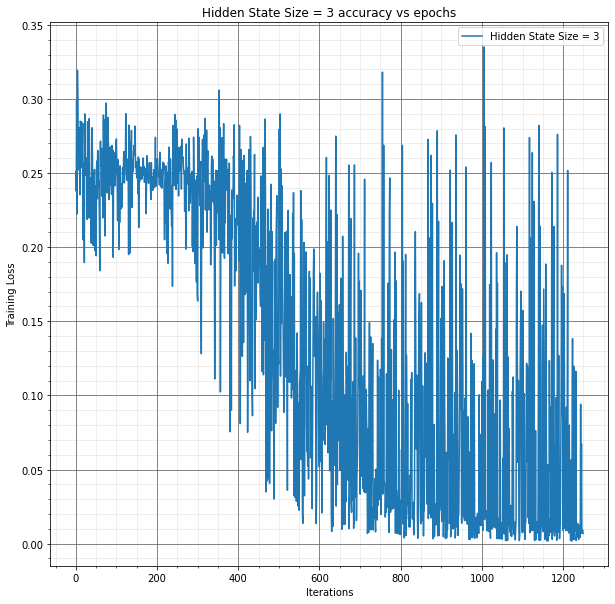

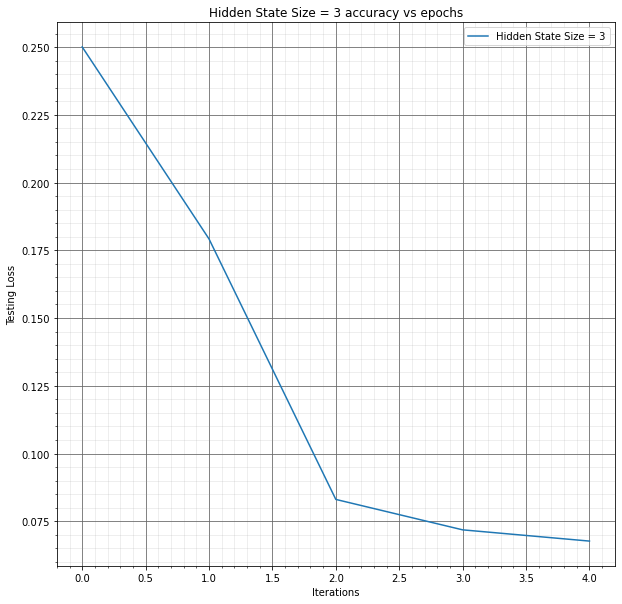

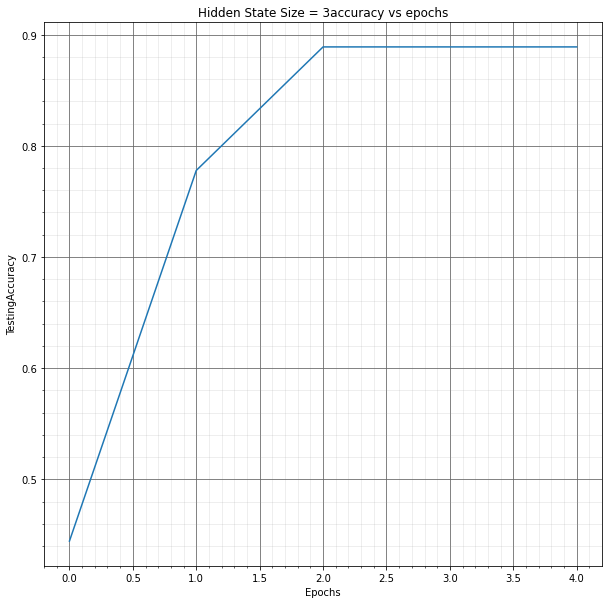

In [103]:
trainingloss1, testloss1, correct_test1 = train_test(model1, criterion_mse, optimizer1)
visualise_loss('Hidden State Size = 3', 'Training', trainingloss1)
visualise_loss('Hidden State Size = 3', 'Testing', testloss1)
visualise_accuracy('Hidden State Size = 3', 'Testing', testloss1, correct_test1)

**For Model 2 with length = 10**

Epoch,1
Epoch,2
Epoch,3
Epoch,4
Epoch,5


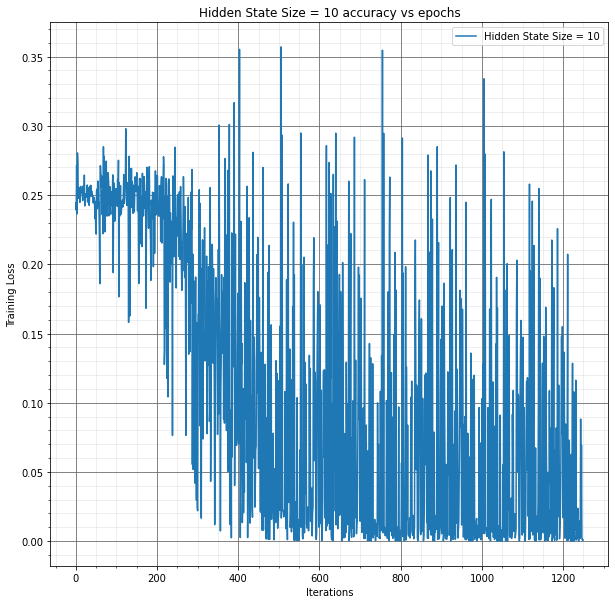

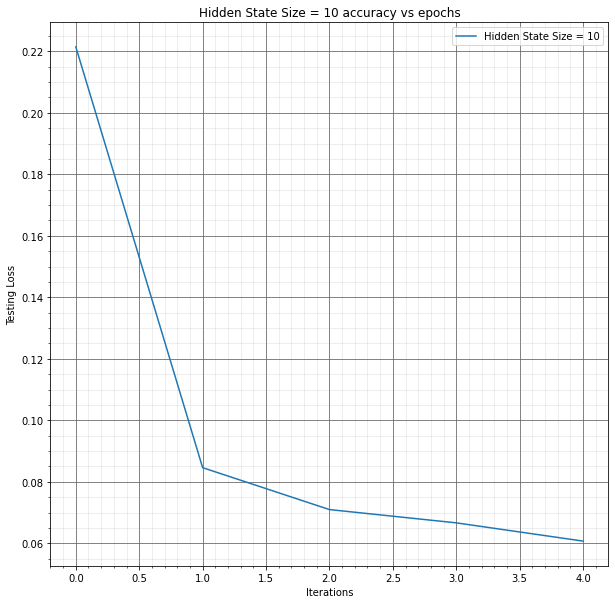

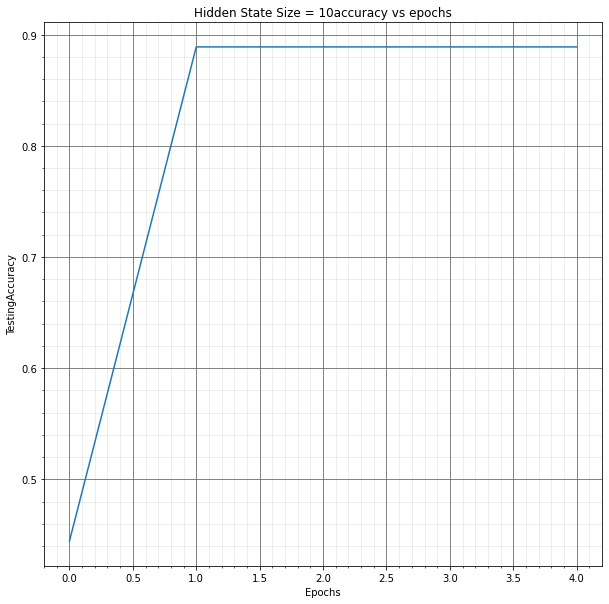

In [104]:
trainingloss2, testloss2, correct_test2 = train_test(model2, criterion_mse, optimizer2)
visualise_loss('Hidden State Size = 10', 'Training', trainingloss2)
visualise_loss('Hidden State Size = 10', 'Testing', testloss2)
visualise_accuracy('Hidden State Size = 10', 'Testing', testloss2, correct_test2)



In [105]:
model1.eval()
correctarr1 = np.zeros(20)
correctarr2 = np.zeros(20)
with torch.no_grad():
    for i in range(len(fintestinput)):
      a=torch.zeros((1,fintestinput[i].shape[0],fintestinput[i].shape[1]))
      a[0]=torch.from_numpy(fintestinput[i])
      output=model1(a.float())
      label=torch.tensor(np.transpose(fintestoutput[i]))
      predicted=torch.zeros(output.shape)
      predicted[output>=0.5]=1
      predicted[output<0.5]=0
      correctarr1[len(label)-1] += (predicted == label.float()).sum().item()/(len(label))


    print('Bit accuracy when hidden states = 3:',(np.sum(correctarr1)/20))

model2.eval()    
with torch.no_grad():
    for i in range(len(fintestinput)):
      a=torch.zeros((1,fintestinput[i].shape[0],fintestinput[i].shape[1]))
      a[0]=torch.from_numpy(fintestinput[i])
      output=model2(a.float())
      label=torch.tensor(np.transpose(fintestoutput[i]))
      predicted=torch.zeros(output.shape)
      predicted[output>0.5]=1
      predicted[output<=0.5]=0
      correctarr2[len(label)-1] += (predicted == label.float()).sum().item()/(len(label))
    print('Bit accuracy when hidden states = 10:',(np.sum(correctarr2)/20))

Bit accuracy when hidden states = 3: 92.08831917437564
Bit accuracy when hidden states = 10: 92.08831917437564


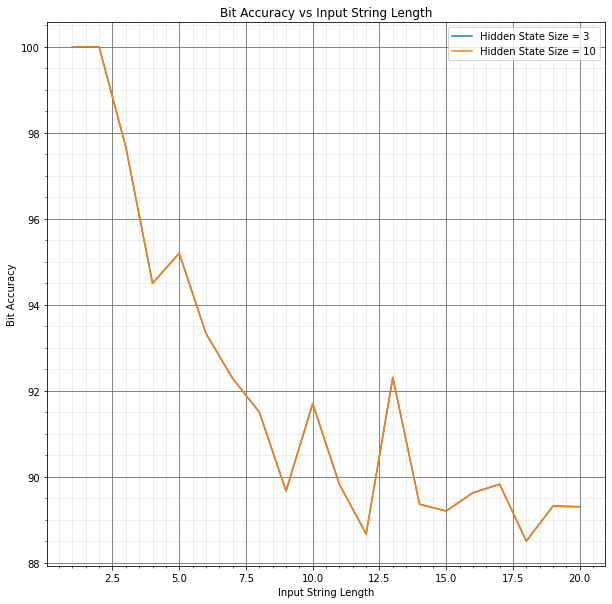

In [106]:
x=np.arange(1,21)
plt.figure(1)
plt.plot(x,correctarr1,label="Hidden State Size = 3")
plt.plot(x,correctarr2,label="Hidden State Size = 10")
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Input String Length')
plt.ylabel('Bit Accuracy')
plt.title('Bit Accuracy vs Input String Length')
plt.legend()
plt.show()

## Taking length (L = 5) and observing loss and accuracy both MSE and CrossEntropyLoss 

In [107]:
learning_rate = 0.01
epochs = 5
model3=LSTM_for_Q3(5)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=learning_rate)

**For Cross Entropy Loss**

Epoch,1
Epoch,2
Epoch,3
Epoch,4
Epoch,5


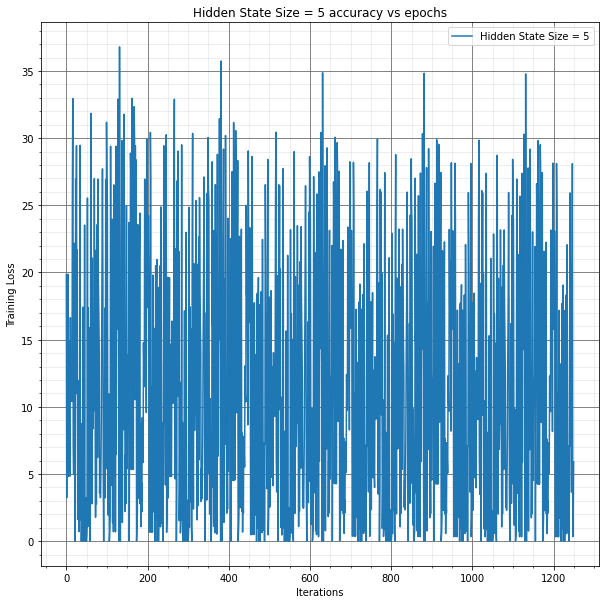

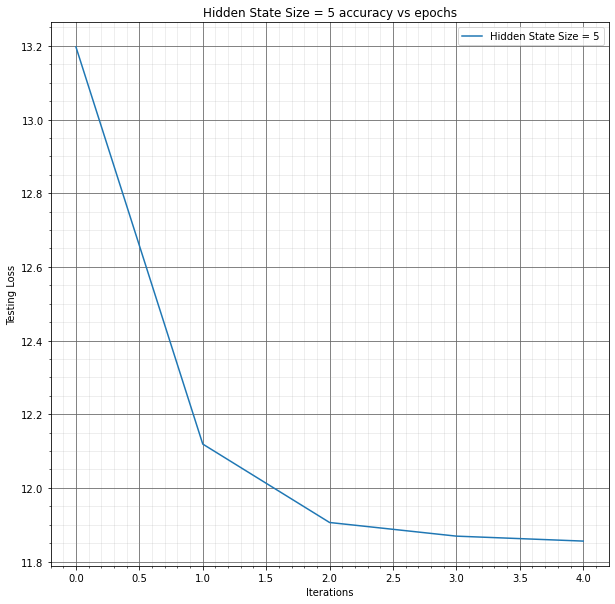

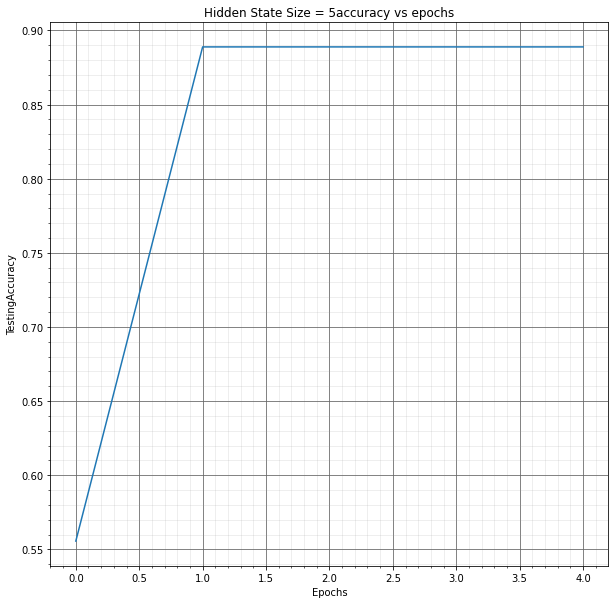

In [108]:
trainingloss3, testloss3, correct_test3 = train_test(model3, criterion, optimizer3)
visualise_loss('Hidden State Size = 5', 'Training', trainingloss3)
visualise_loss('Hidden State Size = 5', 'Testing', testloss3)
visualise_accuracy('Hidden State Size = 5', 'Testing', testloss3, correct_test3)



**For MSE Loss**

In [109]:
model4 = LSTM_for_Q3(5)
optimizer4 = torch.optim.Adam(model4.parameters(), lr=learning_rate)

Epoch,1
Epoch,2
Epoch,3
Epoch,4
Epoch,5


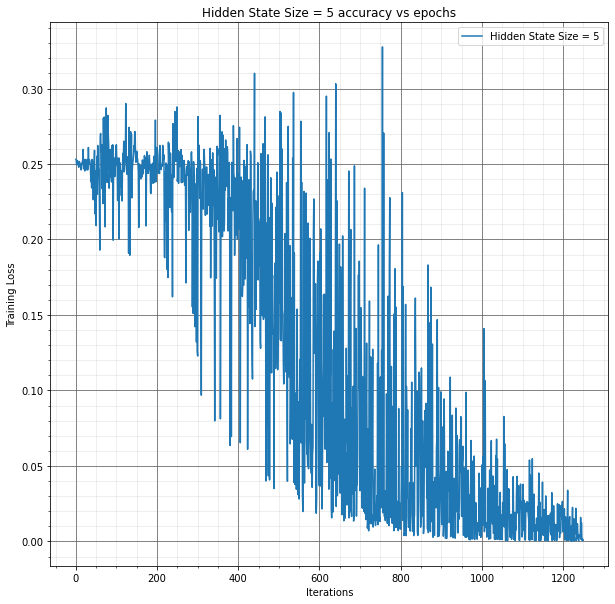

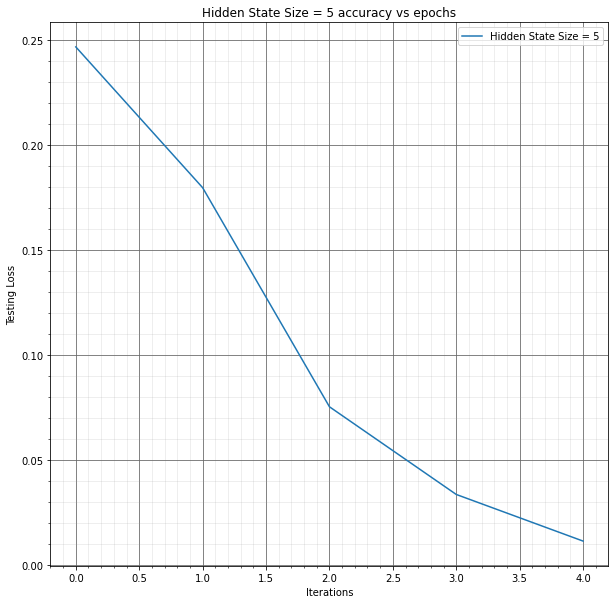

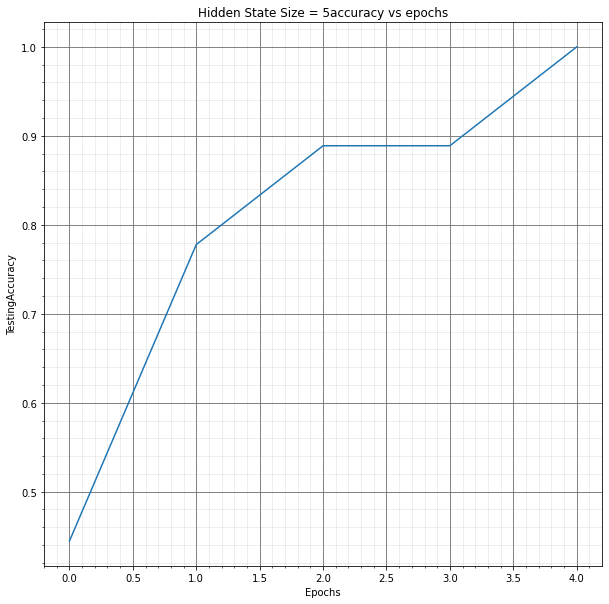

In [110]:
trainingloss4, testloss4, correct_test4 = train_test(model4, criterion_mse, optimizer4)
visualise_loss('Hidden State Size = 5', 'Training', trainingloss4)
visualise_loss('Hidden State Size = 5', 'Testing', testloss4)
visualise_accuracy('Hidden State Size = 5', 'Testing', testloss4, correct_test4)


In [111]:
model3.eval()
correctarr1 = np.zeros(20)
correctarr2 = np.zeros(20)
with torch.no_grad():
    for i in range(len(fintestinput)):
      a=torch.zeros((1,fintestinput[i].shape[0],fintestinput[i].shape[1]))
      a[0]=torch.from_numpy(fintestinput[i])
      output=model3(a.float())
      label=torch.tensor(np.transpose(fintestoutput[i]))
      predicted=torch.zeros(output.shape)
      predicted[output>=0.5]=1
      predicted[output<0.5]=0
      correctarr1[len(label)-1] += (predicted == label.float()).sum().item()/(len(label))


    print('Bit accuracy with MSE:',(np.sum(correctarr1)/20))


model4.eval()    
with torch.no_grad():
    for i in range(len(fintestinput)):
      a=torch.zeros((1,fintestinput[i].shape[0],fintestinput[i].shape[1]))
      a[0]=torch.from_numpy(fintestinput[i])
      output=model4(a.float())
      label=torch.tensor(np.transpose(fintestoutput[i]))
      predicted=torch.zeros(output.shape)
      predicted[output>0.5]=1
      predicted[output<=0.5]=0
      correctarr2[len(label)-1] += (predicted == label.float()).sum().item()/(len(label))
    print('Bit accuracy with Cross Entropy:',(np.sum(correctarr2)/20))


Bit accuracy with MSE: 92.08831917437564
Bit accuracy with Cross Entropy: 100.0


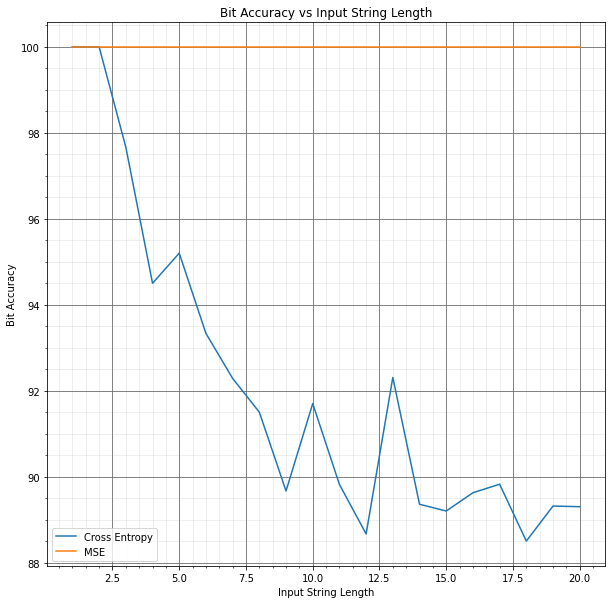

In [112]:
x=np.arange(1,21)
plt.figure(1)
plt.plot(x,correctarr1,label="Cross Entropy")
plt.plot(x,correctarr2,label="MSE")
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Input String Length')
plt.ylabel('Bit Accuracy')
plt.title('Bit Accuracy vs Input String Length')
plt.legend()
plt.show()

## **Now taking inputs of different bit length sequence - 3, 5, 10**



In [120]:
traininput3=[]
trainoutput3=[]
for i in range(250):
  a,b=binsgenerator(3)
  traininput3.append(a)
  trainoutput3.append(b)
  
traininput5=[]
trainoutput5=[]
for i in range(250):
  a,b=binsgenerator(5)
  traininput5.append(a)
  trainoutput5.append(b)
  
traininput10=[]
trainoutput10=[]
for i in range(250):
  a,b=binsgenerator(10)
  traininput10.append(a)
  trainoutput10.append(b)

model5=LSTM_for_Q3(5)
optimizer5 = torch.optim.Adam(model5.parameters(), lr=learning_rate)
model6=LSTM_for_Q3(5)
optimizer6 = torch.optim.Adam(model6.parameters(), lr=learning_rate)
model7=LSTM_for_Q3(5)
optimizer7 = torch.optim.Adam(model7.parameters(), lr=learning_rate)

Epoch,1
Epoch,2
Epoch,3
Epoch,4
Epoch,5


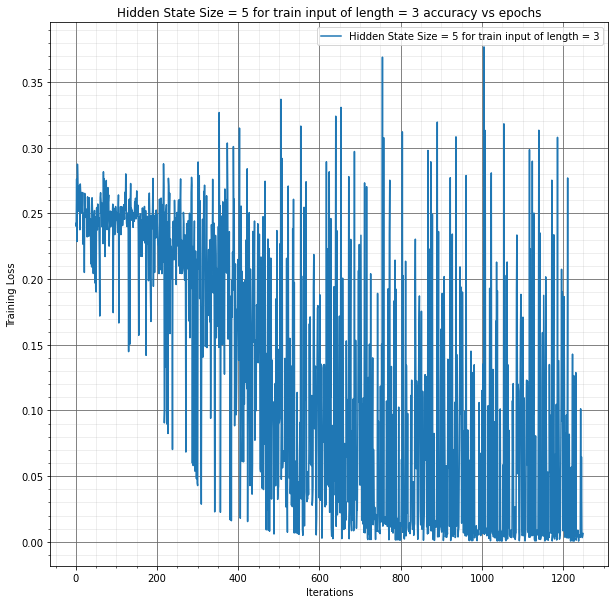

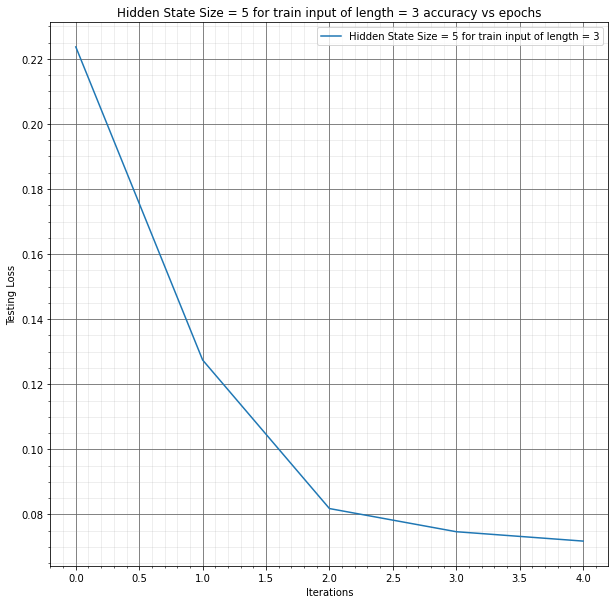

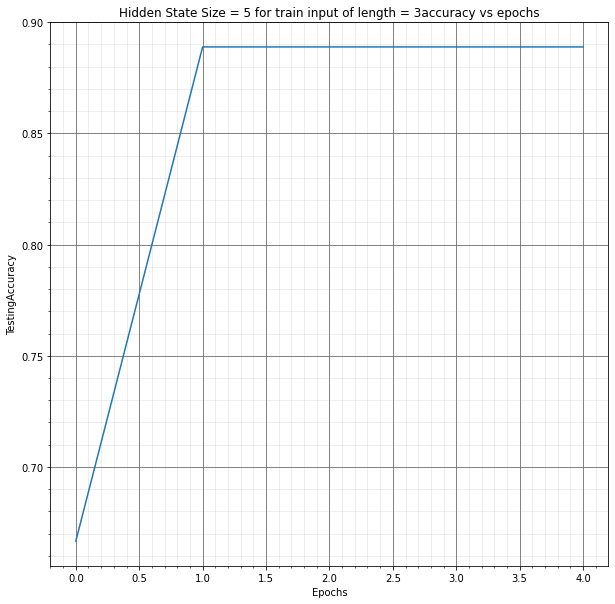

In [121]:
trainingloss5, testloss5, correct_test5 = train_test(model5, criterion_mse, optimizer5)
visualise_loss('Hidden State Size = 5 for train input of length = 3', 'Training', trainingloss5)
visualise_loss('Hidden State Size = 5 for train input of length = 3', 'Testing', testloss5)
visualise_accuracy('Hidden State Size = 5 for train input of length = 3', 'Testing', testloss5, correct_test5)


Epoch,1
Epoch,2
Epoch,3
Epoch,4
Epoch,5


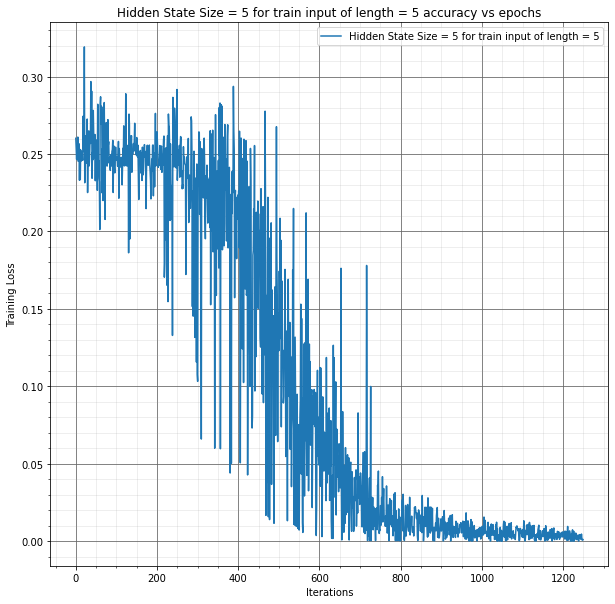

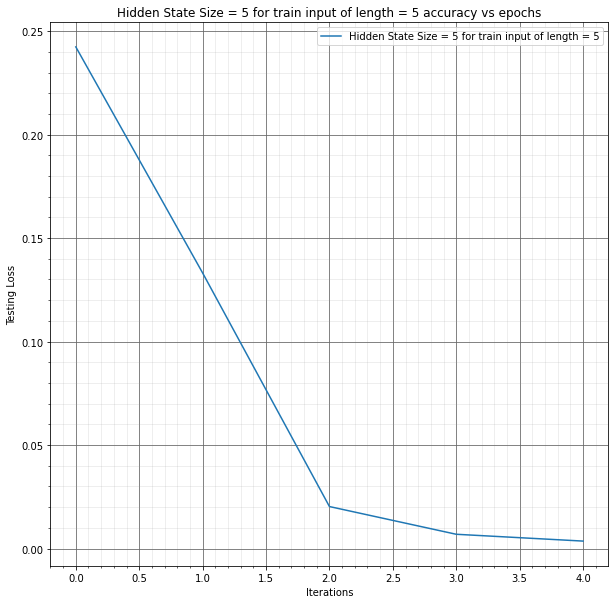

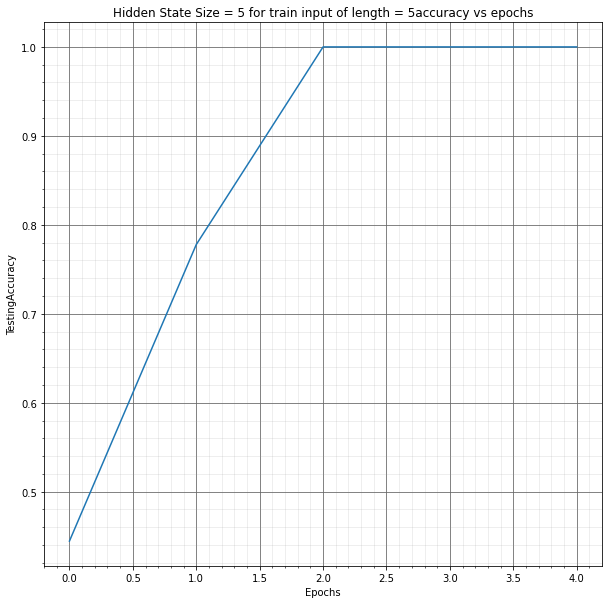

In [122]:
trainingloss6, testloss6, correct_test6 = train_test(model6, criterion_mse, optimizer6)
visualise_loss('Hidden State Size = 5 for train input of length = 5', 'Training', trainingloss6)
visualise_loss('Hidden State Size = 5 for train input of length = 5', 'Testing', testloss6)
visualise_accuracy('Hidden State Size = 5 for train input of length = 5', 'Testing', testloss6, correct_test6)


Epoch,1
Epoch,2
Epoch,3
Epoch,4
Epoch,5


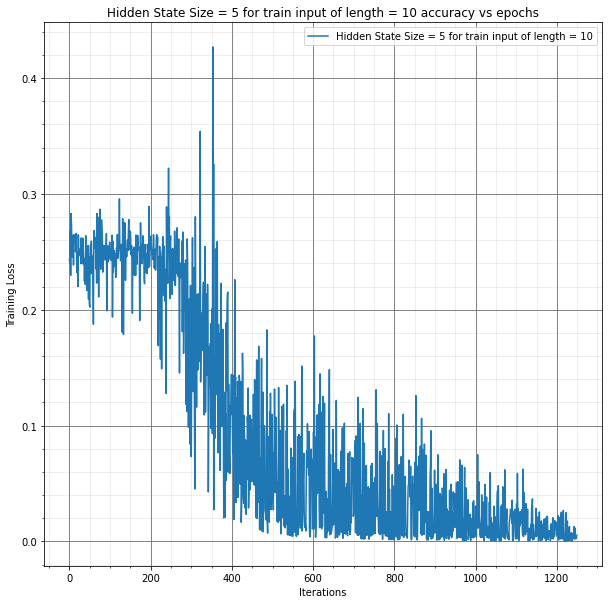

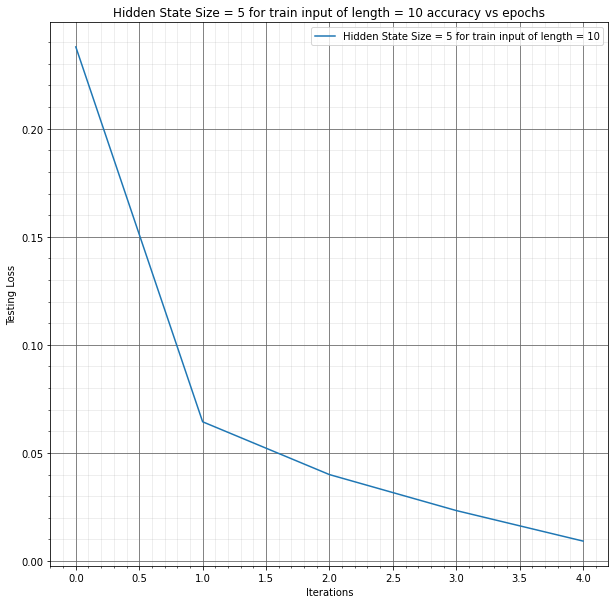

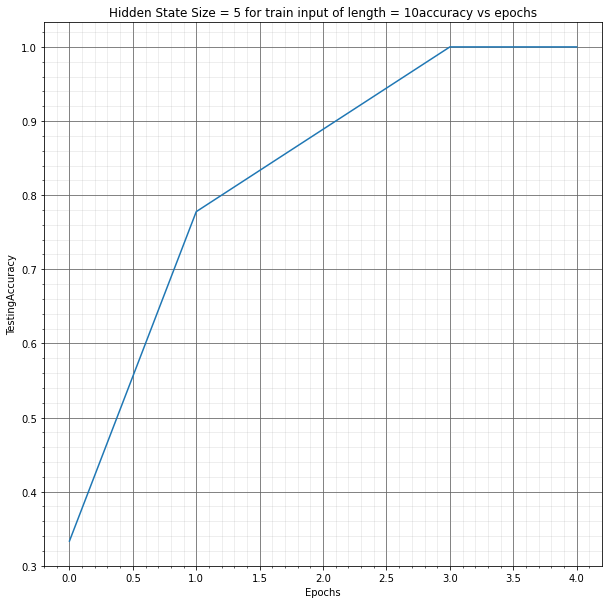

In [123]:
trainingloss7, testloss7, correct_test7 = train_test(model7, criterion_mse, optimizer7)
visualise_loss('Hidden State Size = 5 for train input of length = 10', 'Training', trainingloss7)
visualise_loss('Hidden State Size = 5 for train input of length = 10', 'Testing', testloss7)
visualise_accuracy('Hidden State Size = 5 for train input of length = 10', 'Testing', testloss7, correct_test7)


Bit accuracy after trained only on L=3 inputs: 92.08235426209494
Bit accuracy after trained only on L=5 inputs: 100.0
Bit accuracy after trained only on L=10 inputs: 100.0


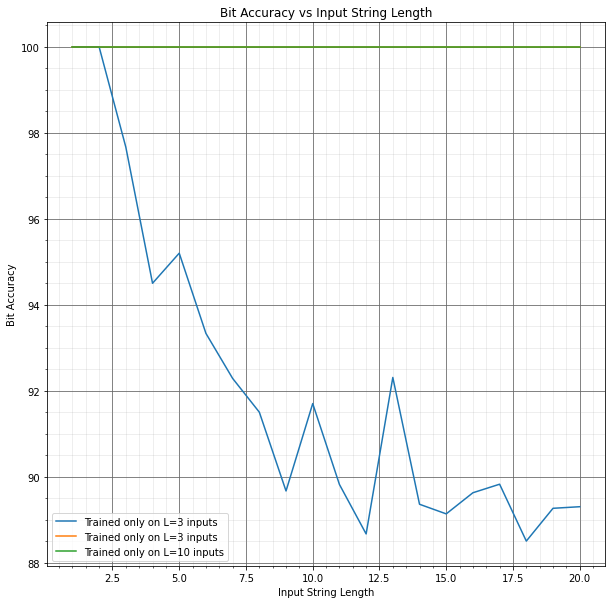

In [124]:
model5.eval()
correctarr1 = np.zeros(20)
correctarr2 = np.zeros(20)
correctarr3 = np.zeros(20)
with torch.no_grad():
    for i in range(len(fintestinput)):
      a=torch.zeros((1,fintestinput[i].shape[0],fintestinput[i].shape[1]))
      a[0]=torch.from_numpy(fintestinput[i])
      output=model5(a.float())
      label=torch.tensor(np.transpose(fintestoutput[i]))
      predicted=torch.zeros(output.shape)
      predicted[output>=0.5]=1
      predicted[output<0.5]=0
      correctarr1[len(label)-1] += (predicted == label.float()).sum().item()/(len(label))


    print('Bit accuracy after trained only on L=3 inputs:',(np.sum(correctarr1)/20))

model6.eval()    
with torch.no_grad():
    for i in range(len(fintestinput)):
      a=torch.zeros((1,fintestinput[i].shape[0],fintestinput[i].shape[1]))
      a[0]=torch.from_numpy(fintestinput[i])
      output=model6(a.float())
      label=torch.tensor(np.transpose(fintestoutput[i]))
      predicted=torch.zeros(output.shape)
      predicted[output>0.5]=1
      predicted[output<=0.5]=0
      correctarr2[len(label)-1] += (predicted == label.float()).sum().item()/(len(label))
    print('Bit accuracy after trained only on L=5 inputs:',(np.sum(correctarr2)/20))

model7.eval()    
with torch.no_grad():
    for i in range(len(fintestinput)):
      a=torch.zeros((1,fintestinput[i].shape[0],fintestinput[i].shape[1]))
      a[0]=torch.from_numpy(fintestinput[i])
      output=model7(a.float())
      label=torch.tensor(np.transpose(fintestoutput[i]))
      predicted=torch.zeros(output.shape)
      predicted[output>0.5]=1
      predicted[output<=0.5]=0
      correctarr3[len(label)-1] += (predicted == label.float()).sum().item()/(len(label))
    print('Bit accuracy after trained only on L=10 inputs:',(np.sum(correctarr3)/20))

x=np.arange(1,21)
plt.figure(1)
plt.plot(x,correctarr1,label="Trained only on L=3 inputs")
plt.plot(x,correctarr2,label="Trained only on L=3 inputs")
plt.plot(x,correctarr3,label="Trained only on L=10 inputs")
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Input String Length')
plt.ylabel('Bit Accuracy')
plt.title('Bit Accuracy vs Input String Length')
plt.legend()
plt.show()